# Change of Hazard/Risk Assessment for Wildfire

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This notebook is a supplement to the Hazard and Risk assessment notebooks.
It depends on the outputs of these notebooks to function.

In the following, differences between the computed historical and future wildfire susceptibility, hazard and risk are visualized, with projected changes of the machine learning model input parameters providing additional context to understand found differences.

## Load libraries

Importing libraries required for the processing and visualization of data.


:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html): File path manipulation and file system access.
- [numpy](https://numpy.org/): A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- [xarray](https://xarray.pydata.org/): An open-source project and Python package that aims to bring the labeled data power of pandas to the physical sciences, by providing N-dimensional variants of the core pandas data structures.
- [rioxarray](https://corteva.github.io/rioxarray/stable/): Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray.
- [matplotlib.pyplot](https://matplotlib.org/): Matplotlib's plotting interface, providing functions for creating and customizing plots. %matplotlib inline is an IPython magic command to display Matplotlib plots inline within the Jupyter Notebook or IPython console.
:::


In [1]:
import pathlib

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches

## Data configuration

:::{important}
The data visualized in this notebook is created by the hazard and risk assessment workflows.
Only data configurations for which these workflow notebooks have been run previously to generate the input data for this notebook will work.
:::

### Region selection

Use the region name assigned in the hazard and risk notebooks.

In [2]:
areaname = "Catalonia" # example configuration: Catalonia

### Historical and future configuration

Choose a [historical period](Hazard_assessment_FIRE_ML.ipynb#select-historical-period-for-model-training) and [future scenario, period and climate model](Hazard_assessment_FIRE_ML.ipynb#future-scenario-and-period-and-climate-model-selection) as in the Hazard assessment.

:::{tip}
You can return to this point of the workflow and rerun the following cells for different combinations of RCP scenario, time period and climate model to explore different the risk in different futures.
:::

In [3]:
hist_period = "199110"

future_scenario = "RCP45"
future_period = "202140"
climate_model = "CLMcom_CCLM"

## Preparation

Load a raster mask that defines the region for plotting:

### Path configuration

In [4]:
data_path_area = pathlib.Path(f"./data_{areaname}")

# Output rasters from hazard and risk assessment
suscep_path = data_path_area / "susceptibility"
hazard_path = data_path_area / "hazard"
risk_path = data_path_area / "risk"

# Resized ECLIPS-2.0 data folder (region-specific)
clim_path = data_path_area / "climate"

# DEM raster for masking
dem_path = data_path_area / "dem"
dem_path_clip = dem_path / "dem_clip.tif" # output

# Filename part for historical susceptibility/hazard/risk
hist_config_id = f"HIST_{hist_period}"
hist_period_print = hist_period[:-2] + "-" + hist_period[-2:]

# Filename part for future susceptibility/hazard/risk
future_config_id = f"{future_scenario}_{climate_model}_{future_period}"
future_period_print = future_period[:-2] + "-" + future_period[-2:]

# Output folder for map plots
maps_path = data_path_area / "maps"
maps_path.mkdir(parents=True, exist_ok=True)

### Plot function for difference maps

In [5]:
ref = xr.open_dataarray(dem_path_clip).squeeze()
mask = np.isnan(ref.values)

In [6]:
def plot_difference(ax, hist, future, classes_values, mask=None, title=None):
    classes_colors = ['navy',  'lightgray', 'darkred']
    classes_names = ['Decrease', 'No changes', 'Increase']
    cmap = matplotlib.colors.ListedColormap(classes_colors)
    norm = matplotlib.colors.BoundaryNorm(classes_values, cmap.N)
    classes_handles = [matplotlib.patches.Patch(color=color) for color in classes_colors]
    # Compute difference of fields
    diff = np.ma.masked_array(future - hist, mask=mask)
    # Plot with legend and disable plot frame
    ax.imshow(diff, cmap=cmap, norm=norm)
    ax.legend(handles=classes_handles, labels=classes_names, loc="lower right")
    ax.axis("off")
    ax.set_title(title)

## Difference of Susceptibility

Difference of Susceptibility maps between the historical and future climate:

In [7]:
suscep_hist = xr.open_dataarray(suscep_path / f"suscep_{hist_config_id}.tif").squeeze()
suscep_future = xr.open_dataarray(suscep_path / f"suscep_{future_config_id}.tif").squeeze()

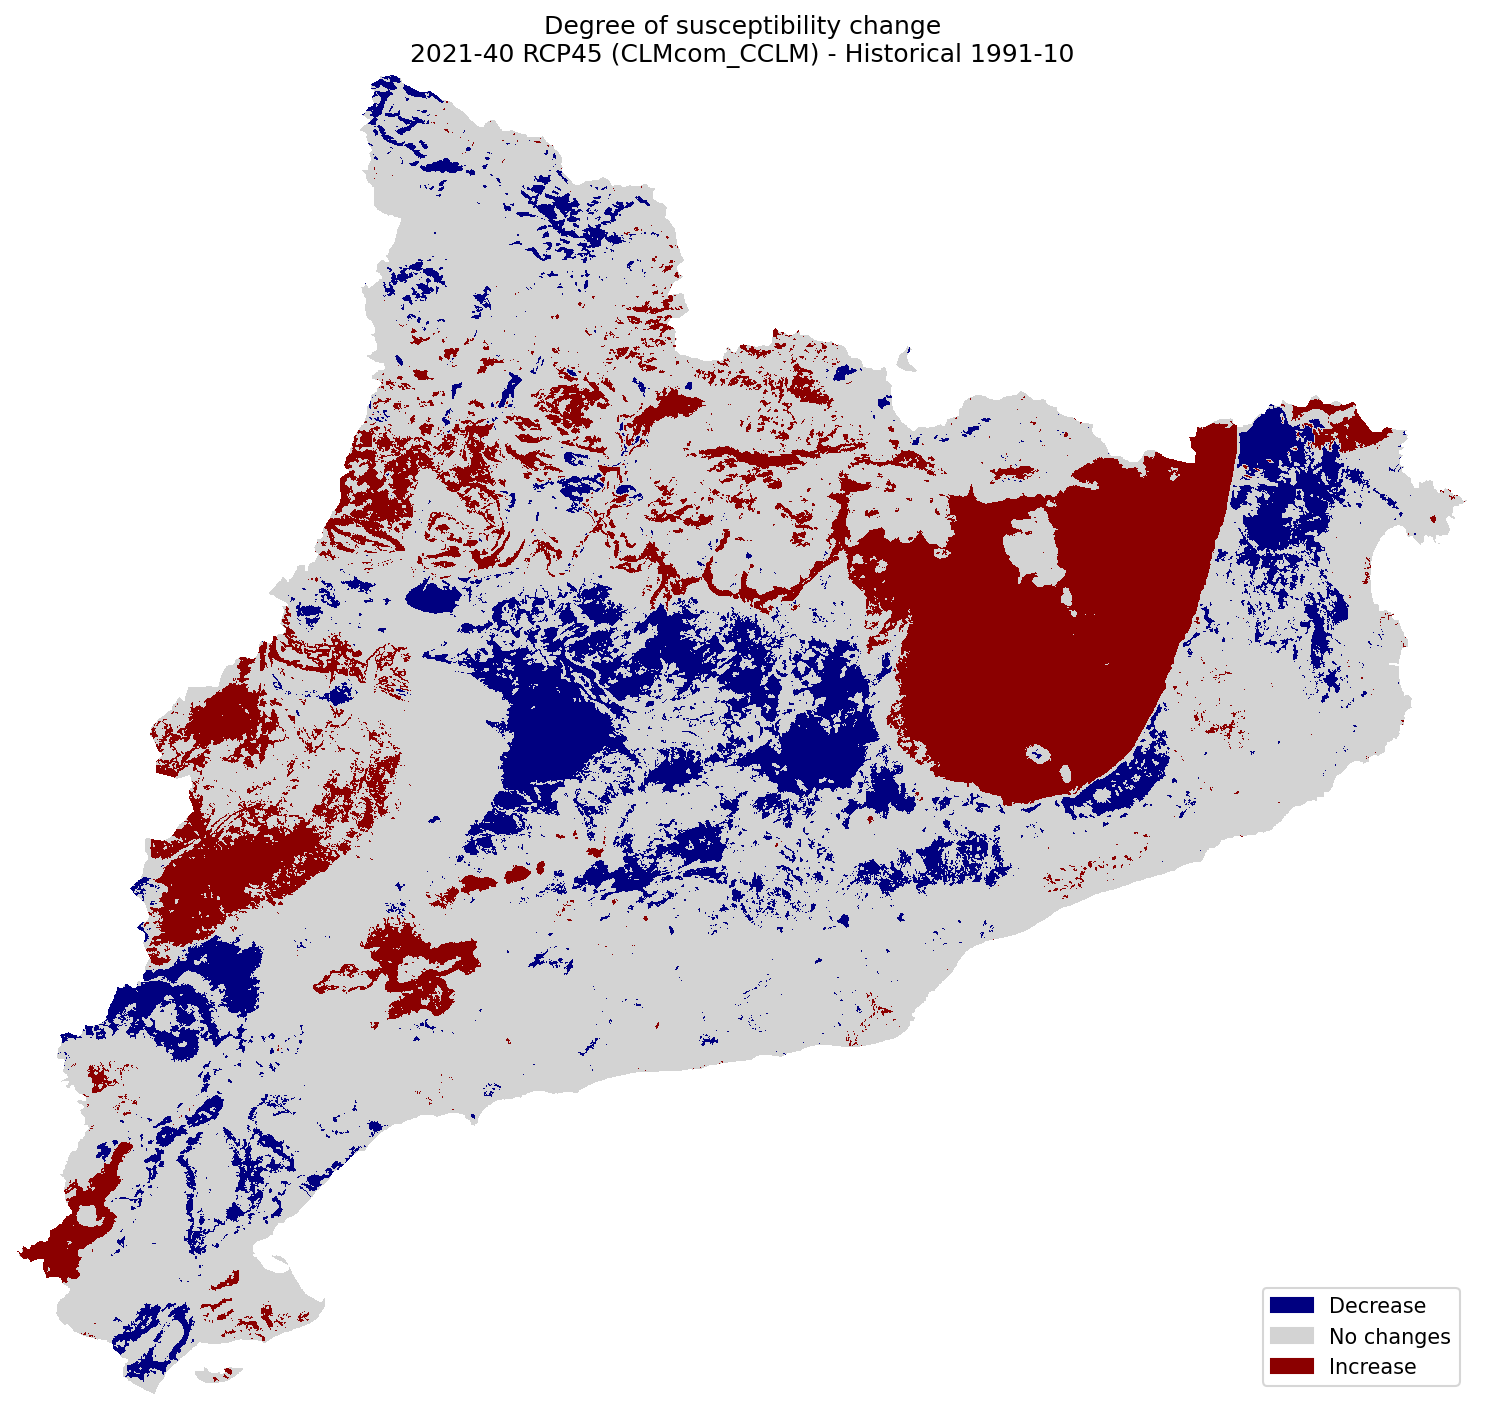

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)

plot_difference(ax, suscep_hist, suscep_future, classes_values=[-3.1, -0.1, 0.1, 3], mask=mask, title=(
    "Degree of susceptibility change\n"
    f"{future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}"
))

fig.tight_layout()
fig.savefig(maps_path / f"change_suscep_{hist_config_id}_{future_config_id}.png")

## Difference of Hazard

In [9]:
hazard_hist = xr.open_dataarray(hazard_path / f"hazard_{hist_config_id}.tif").squeeze()
hazard_future = xr.open_dataarray(hazard_path / f"hazard_{future_config_id}.tif").squeeze()

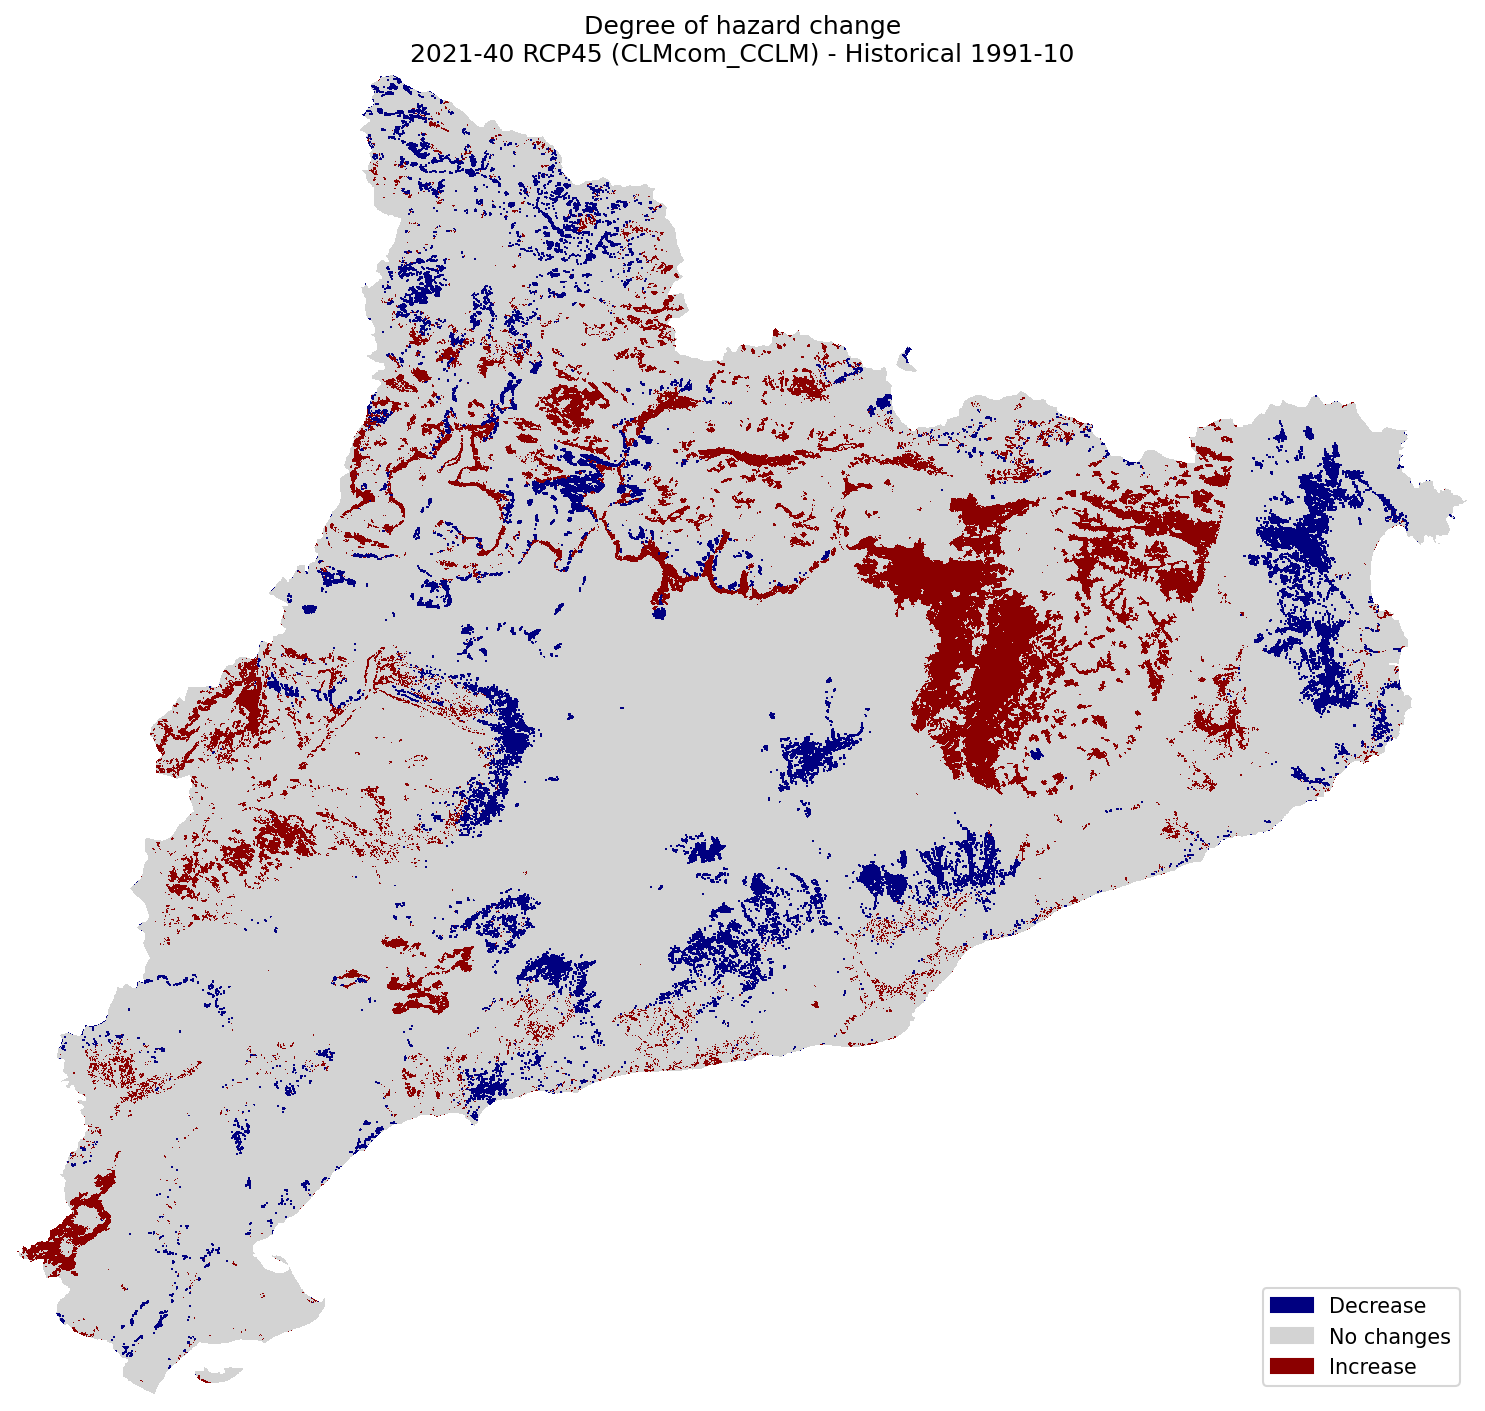

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)

plot_difference(ax, hazard_hist, hazard_future, classes_values=[-5.1, 0, 0.1, 5], mask=mask, title=(
    "Degree of hazard change\n"
    f"{future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}"
))

fig.tight_layout()
fig.savefig(maps_path / f"change_hazard_{hist_config_id}_{future_config_id}.png")

## Difference of Risk

### Economy

In [11]:
risk_econ_hist = xr.open_dataarray(risk_path / f"risk1_economical_{hist_config_id}.tif").squeeze()
risk_econ_future = xr.open_dataarray(risk_path / f"risk1_economical_{future_config_id}.tif").squeeze()

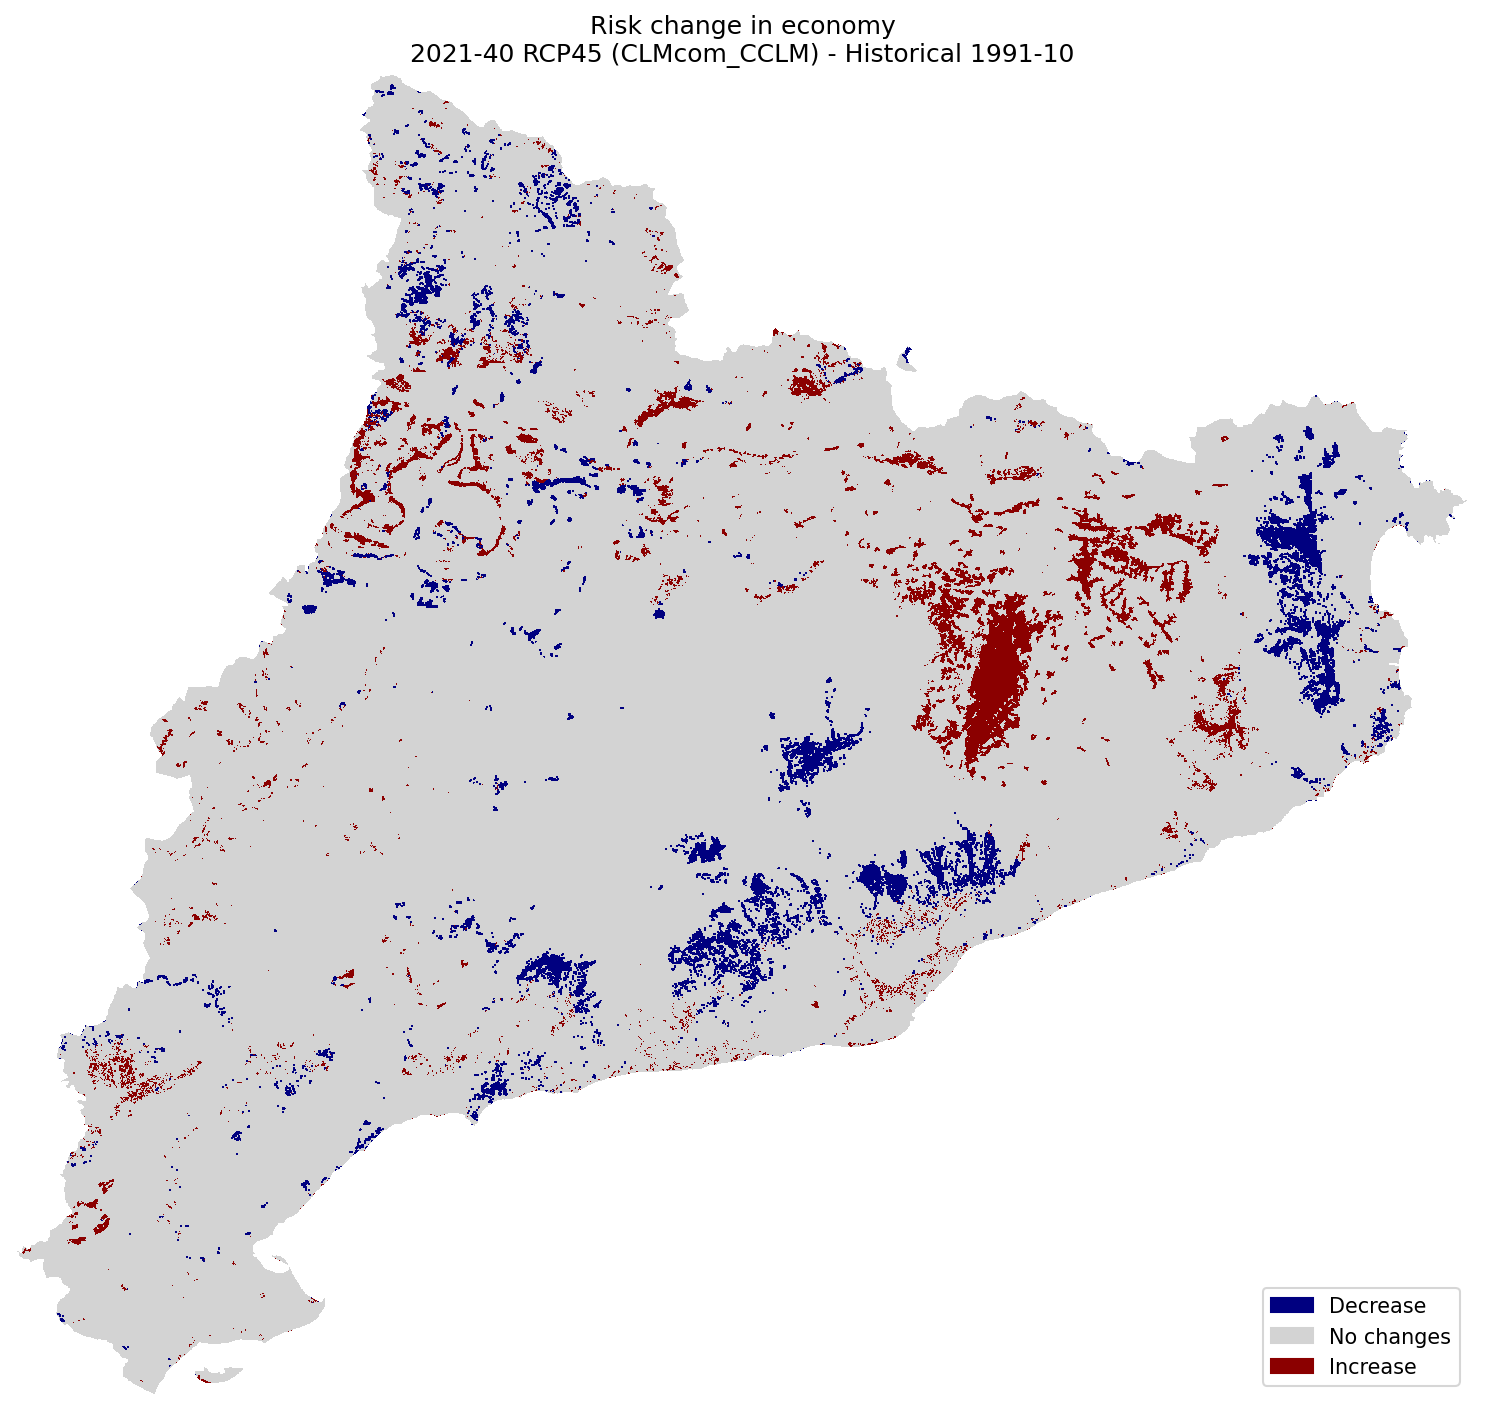

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)

plot_difference(ax, risk_econ_hist, risk_econ_future, classes_values=[-5.1, 0, 0.1, 5], mask=mask, title=(
    "Risk change in economy\n"
    f"{future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}"
))

fig.tight_layout()
fig.savefig(maps_path / f"change_risk1_economical_{hist_config_id}_{future_config_id}.png")

### Population

In [13]:
risk_pop_hist = xr.open_dataarray(risk_path / f"risk1_population_{hist_config_id}.tif").squeeze()
risk_pop_future = xr.open_dataarray(risk_path / f"risk1_population_{future_config_id}.tif").squeeze()

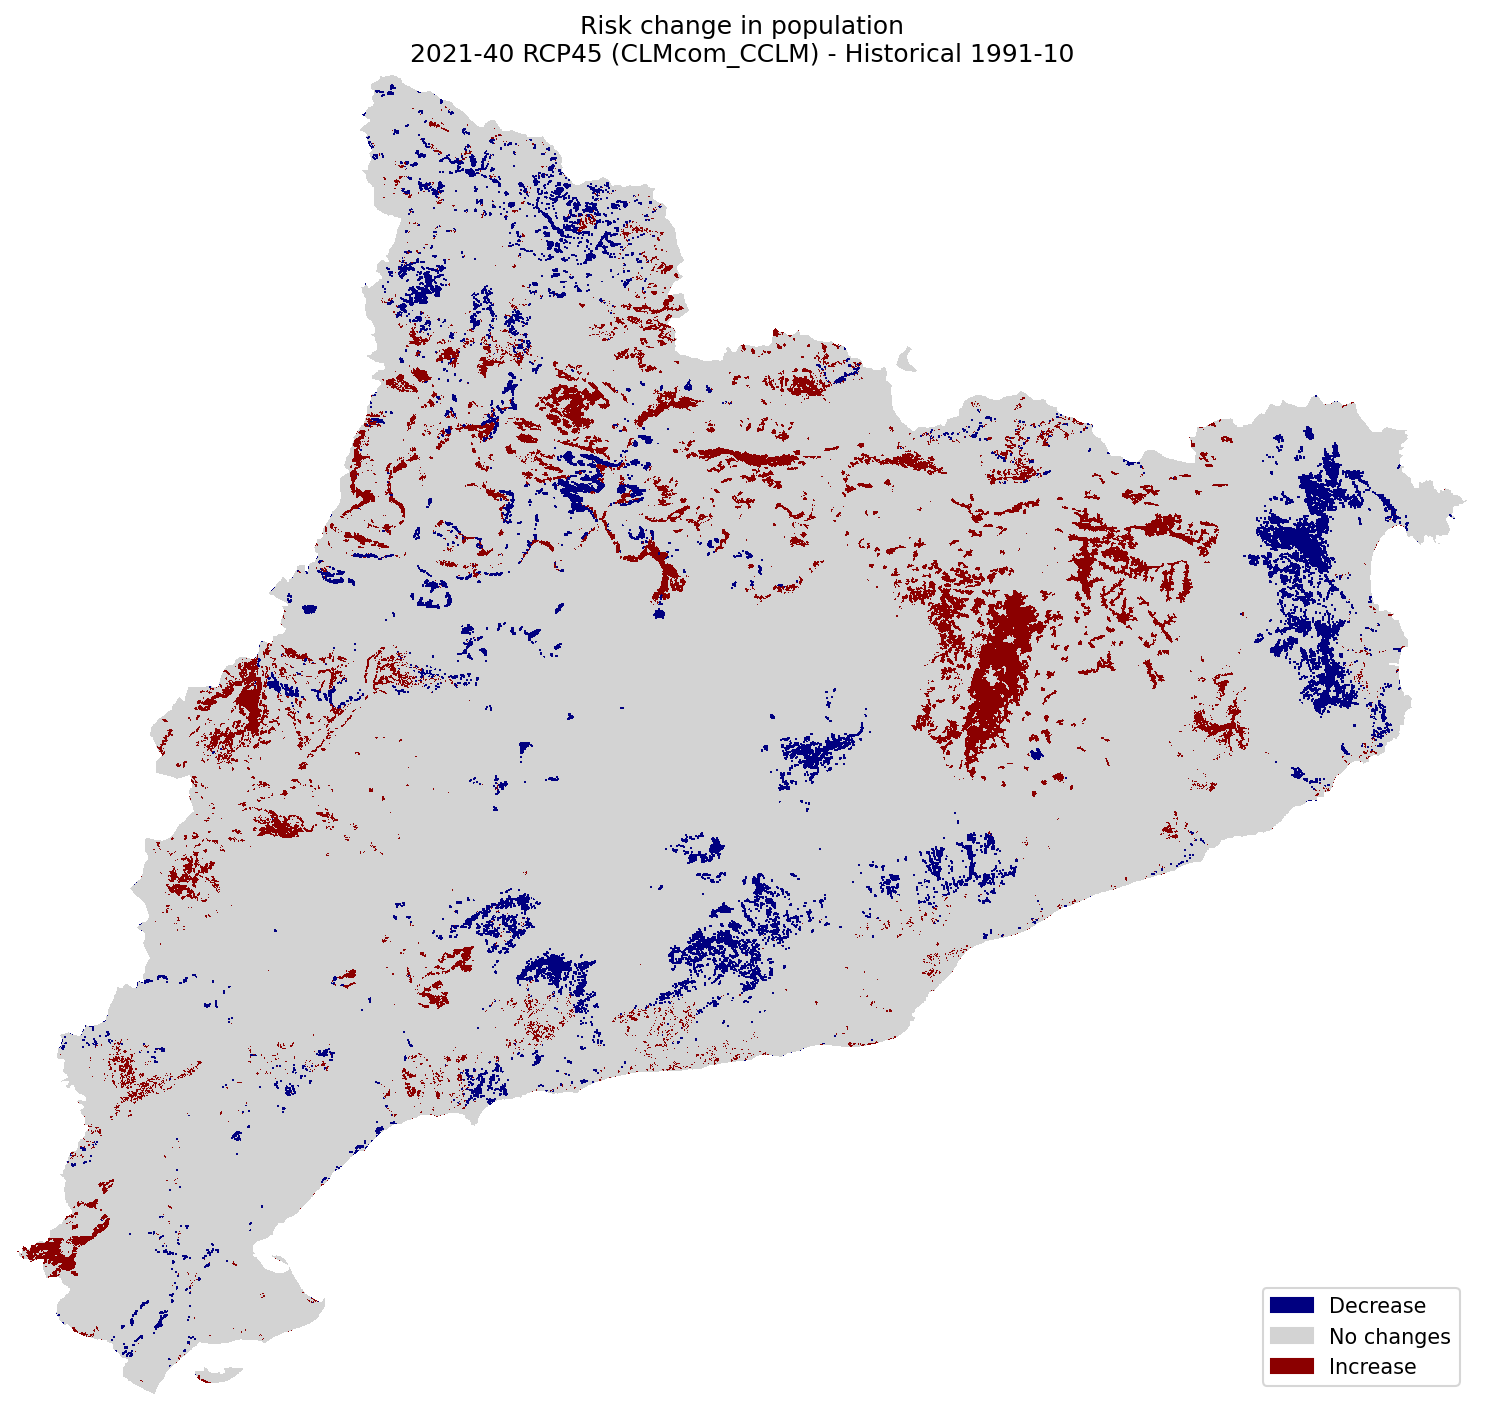

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)

plot_difference(ax, risk_pop_hist, risk_pop_future, classes_values=[-5.1, 0, 0.1, 5], mask=mask, title=(
    "Risk change in population\n"
    f"{future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}"
))

fig.tight_layout()
fig.savefig(maps_path / f"change_risk1_population_{hist_config_id}_{future_config_id}.png")

### Roads

In [15]:
risk_roads_hist = xr.open_dataarray(risk_path / f"risk2_roads_{hist_config_id}.tif").squeeze()
risk_roads_future = xr.open_dataarray(risk_path / f"risk2_roads_{future_config_id}.tif").squeeze()

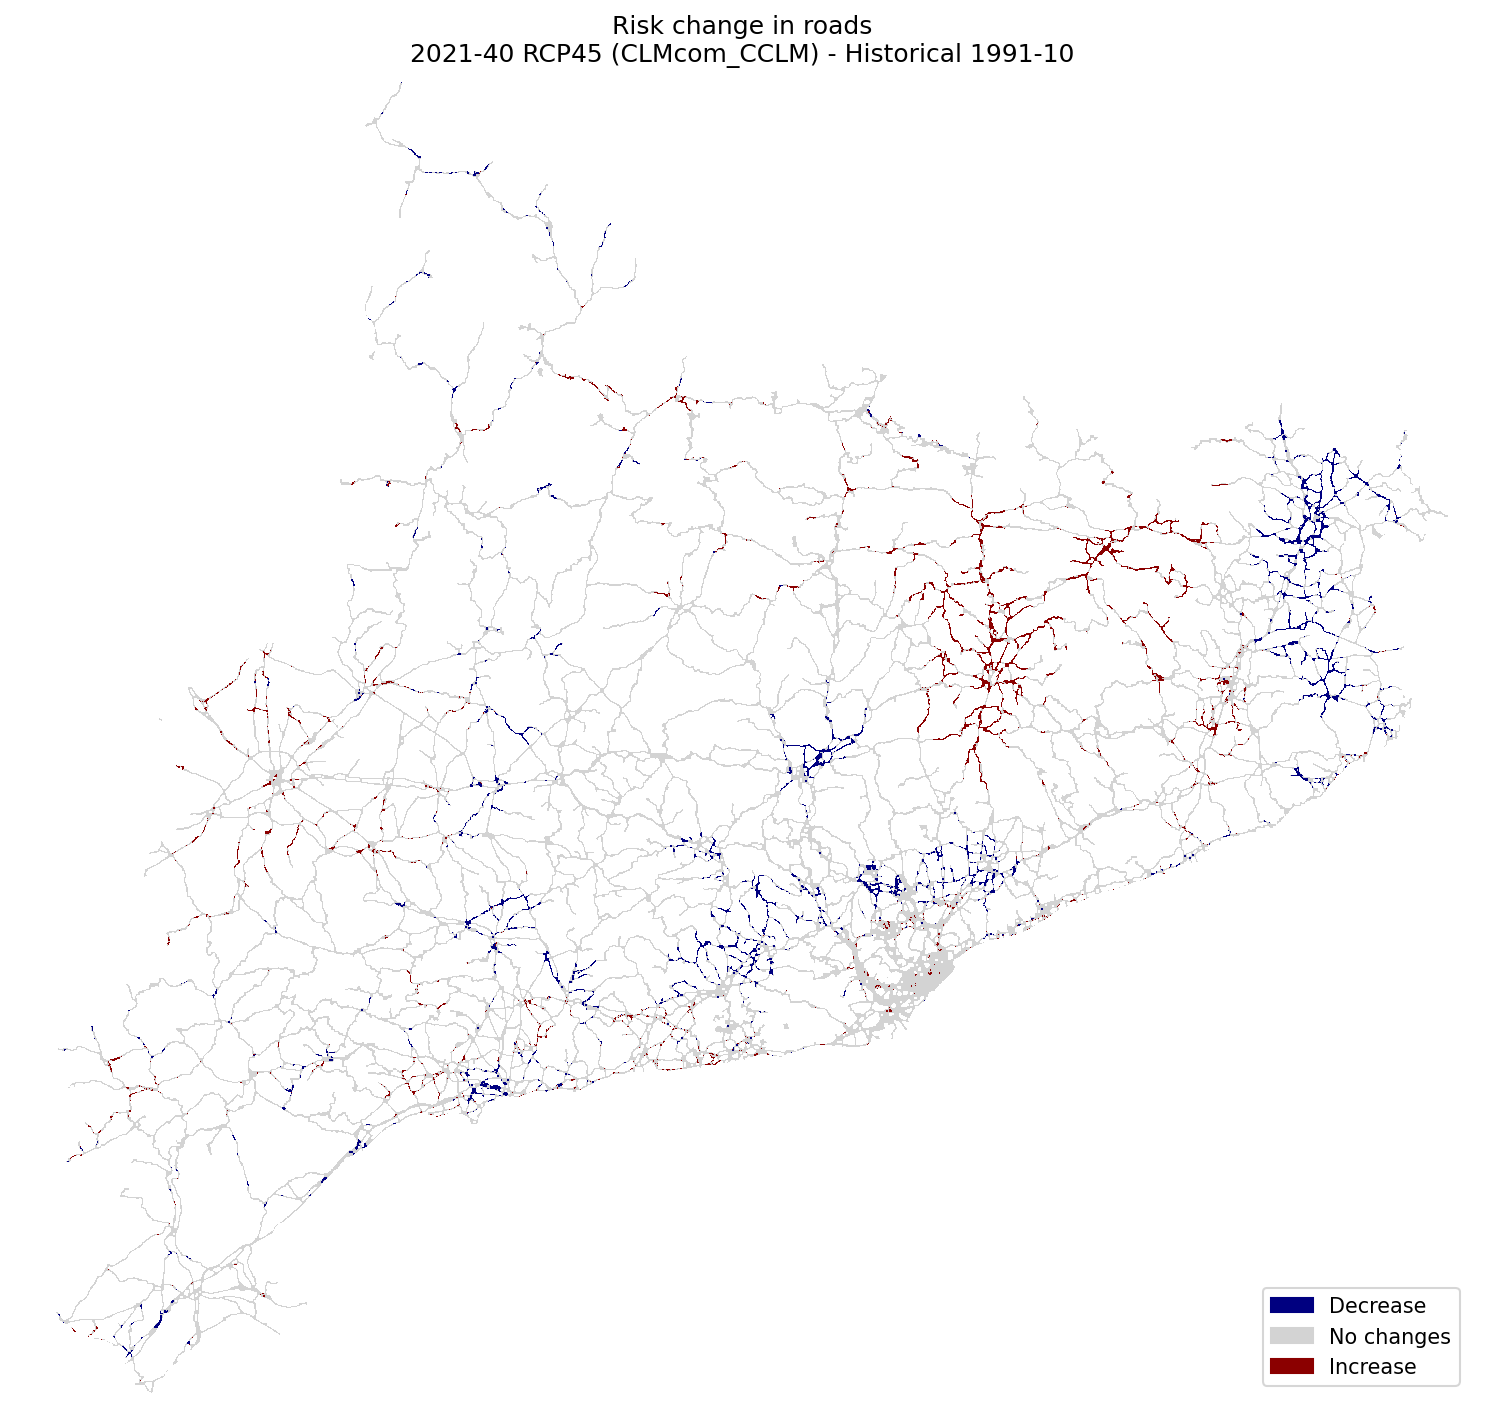

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)

plot_difference(ax, risk_roads_hist, risk_roads_future, classes_values=[-5.1, 0, 0.1, 5], mask=mask, title=(
    "Risk change in roads\n"
    f"{future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}"
))

fig.tight_layout()
fig.savefig(maps_path / f"change_risk2_roads_{hist_config_id}_{future_config_id}.png")

## Climate variable changes in time

Let's check the climate input to find the logic behind changes in the risk hazard or susceptibility maps.

### Load data

In [17]:
hist_clim_files = list(sorted((clim_path / hist_config_id).glob("*.tif")))
future_clim_files = list(sorted((clim_path / future_config_id).glob("*.tif")))

In [18]:
def rename(ds):
    name = pathlib.Path(ds.encoding["source"]).name
    name = "_".join(name.split("_")[:-1])
    return ds["band_data"].rename(name).squeeze()

hist_clim = xr.open_mfdataset(hist_clim_files, preprocess=rename)
future_clim = xr.open_mfdataset(future_clim_files, preprocess=rename)

### Plot difference maps

In [19]:
var_names = list(hist_clim.data_vars)

nvars = len(var_names)
ncols = 3
nrows = int(np.ceil(nvars / ncols))

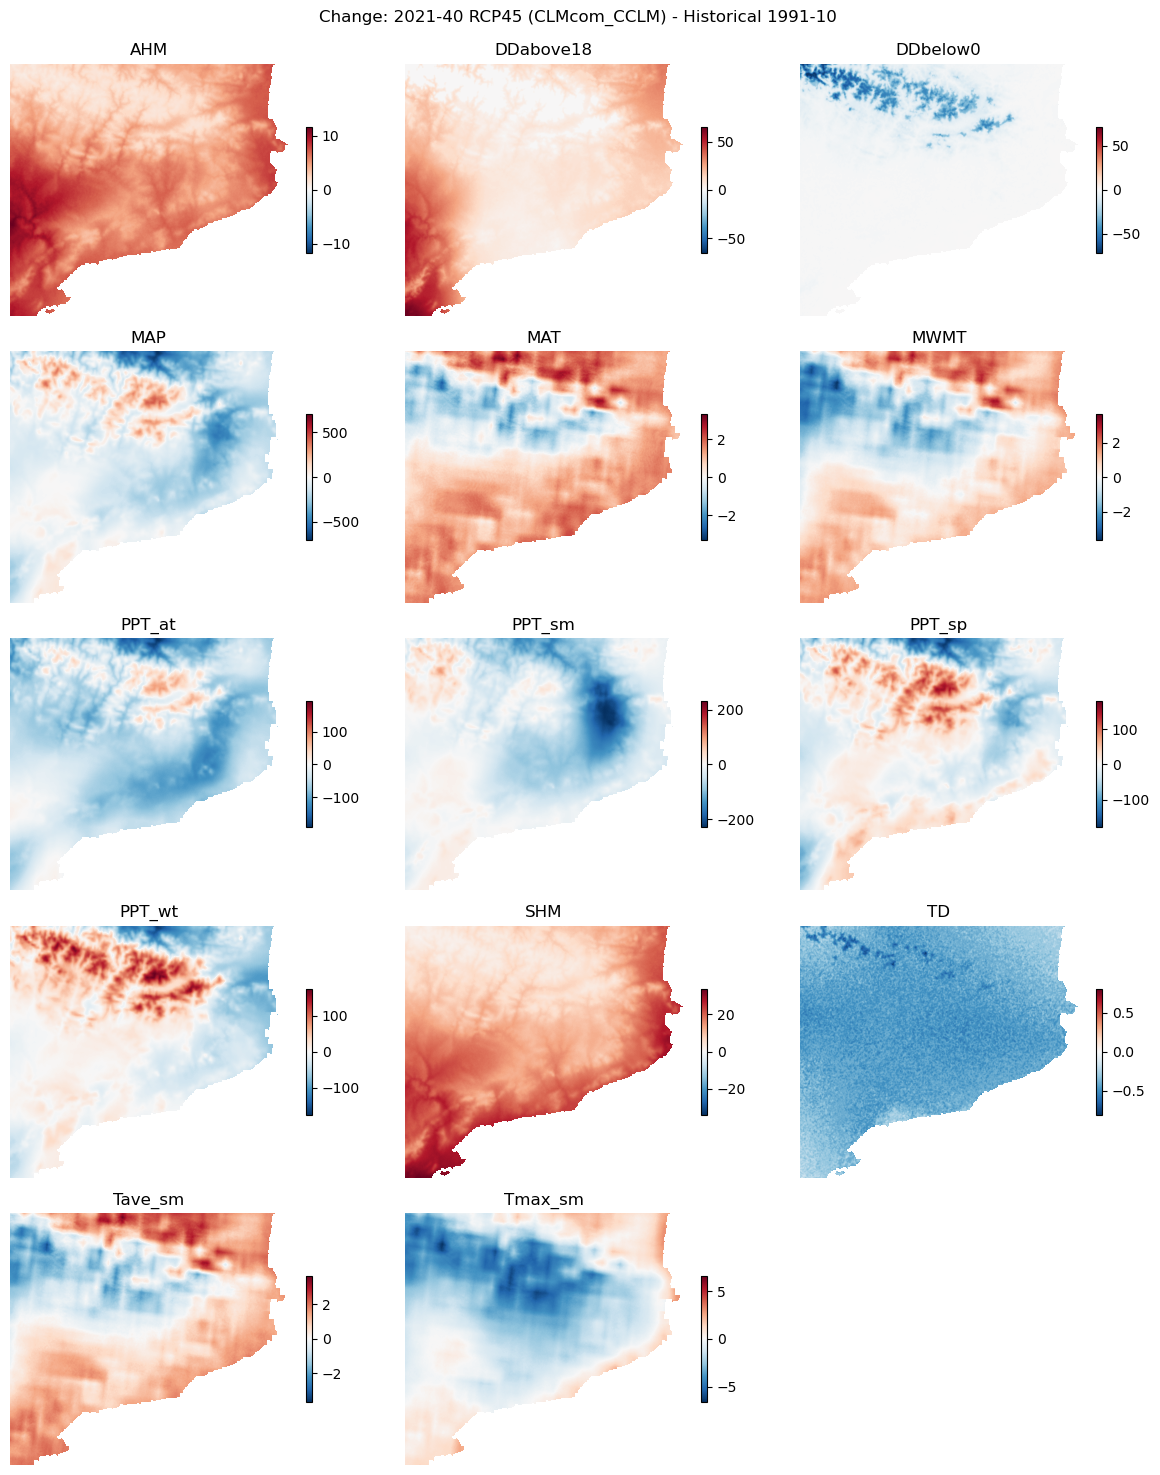

In [20]:
fig, axs = plt.subplots(nrows, ncols, figsize=(12, nrows*3))
axs = axs.flatten()

fig.suptitle(f"Change: {future_period_print} {future_scenario} ({climate_model}) - Historical {hist_period_print}\n")

# Fill panels with difference plot for each variable
for ax, var_name in zip(axs, var_names):
    diff_clim = future_clim[var_name] - hist_clim[var_name]
    maxval = np.max(np.abs(diff_clim)).values # to enforce symmetric colorbar range
    im = ax.imshow(diff_clim.values, vmin=-maxval, vmax=maxval, cmap="RdBu_r")
    plt.colorbar(im, ax=ax, shrink=0.5)
    ax.set_title(var_name)
    ax.axis("off")

# Remove left-over plot panels
for ax in axs[nvars:]:
    ax.remove()

fig.tight_layout()
fig.savefig(maps_path / f"change_clim_vars_{hist_config_id}_{future_config_id}.png")

## Contributors

- Andrea Trucchia (Andrea.trucchia@cimafoundation.org)
- Farzad Ghasemiazma (Farzad.ghasemiazma@cimafoundation.org)
- Giorgio Meschi (Giorgio.meschi@cimafoundation.org)